In [1]:
import pandas as pd
# coding: UTF-8
import time
import torch
import warnings 
warnings.filterwarnings("ignore")
import numpy as np
import torch.utils.data as data
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score
from torch.utils.data import SubsetRandomSampler
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from units import *
import pyreadstat

### 数据预处理

In [2]:
save='./统计指标3/3/'
df, meta = pyreadstat.read_sav('./data/调整后数据.sav')
df.columns=['aweme_id','collect_count','create_time','digg_count','duration','follower_count','gender','share_count','comment_count','comment_get','variation','arousal','intention_counts']
rawdata=df[['collect_count','create_time','digg_count','duration','follower_count','gender','share_count','comment_get','comment_count','variation','arousal','intention_counts']]
rawdata=rawdata[rawdata['variation'].notna()]
rawdata=rawdata[rawdata['arousal'].notna()]
# rawdata['intention_counts']=rawdata['intention_counts']/rawdata['comment_get']
# rawdata.drop('comment_get',axis=1)
columns=['collect_count', 'create_time','digg_count','duration',
       'follower_count', 'gender', 'share_count','comment_count','comment_get',
        'variation', 'arousal' ,'V*A', 'intention_counts']
rawdata['V*A']=rawdata['variation']*rawdata['arousal']
rawdata=rawdata[columns]
select_num=220
select_pd=pd.DataFrame()
select_pd=select_pd.append(rawdata.sort_values(by=['variation','arousal'],ascending=[False,False]).head(select_num),ignore_index=True)
select_pd=select_pd.append(rawdata.sort_values(by=['arousal','variation'],ascending=[False,False]).head(select_num),ignore_index=True)
select_pd=select_pd.append(rawdata.sort_values(by=['variation','arousal'],ascending=[True,False]).head(select_num),ignore_index=True)
select_pd=select_pd.append(rawdata.sort_values(by=['arousal','variation'],ascending=[True,False]).head(select_num),ignore_index=True)
columns=['collect_count', 'create_time','digg_count','duration',
       'follower_count', 'gender', 'share_count','comment_count','comment_get', 
        'variation',
         'arousal',
         'V*A',
         'intention_counts']
rawdata=rawdata[columns]
rawdata

,collect_count,create_time,digg_count,duration,follower_count,gender,share_count,comment_count,comment_get,variation,arousal,V*A,intention_counts
0,354.0,1.536720e+09,171914.0,59000.0,1375225.0,1.0,2250.0,2494.0,40.0,0.259775,-0.179440,-0.046614,9.0
1,6463.0,1.551005e+09,551236.0,52234.0,4568793.0,2.0,36969.0,10767.0,20.0,0.094975,-0.215612,-0.020478,6.0
2,4196.0,1.551282e+09,164671.0,15000.0,588090.0,1.0,13965.0,3153.0,40.0,0.199953,-0.858012,-0.171562,11.0
3,154.0,1.551913e+09,31207.0,42121.0,1030347.0,2.0,286.0,391.0,20.0,0.264027,-0.304219,-0.080322,2.0
4,9427.0,1.554560e+09,545115.0,40239.0,588104.0,1.0,24688.0,9003.0,39.0,0.224461,-0.723178,-0.162326,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3517,70.0,1.673417e+09,466.0,40402.0,20661.0,0.0,39.0,481.0,40.0,0.135007,0.022623,0.003054,13.0
3518,359.0,1.673593e+09,935.0,60256.0,5662.0,0.0,51.0,71.0,33.0,0.308557,-0.702568,-0.216782,11.0
3519,52.0,1.673602e+09,988.0,58300.0,33626.0,0.0,16.0,87.0,14.0,0.259682,-0.003258,-0.000846,1.0
3520,19.0,1.673618e+09,566.0,16742.0,2789.0,0.0,399.0,71.0,37.0,0.487982,-0.731718,-0.357065,4.0


### 数据归一化

In [3]:
scaler = MinMaxScaler() #实例化
rawdata = scaler.fit_transform(rawdata) #fit，在这里本质是生成min(x)和max(x)
rawdata = pd.DataFrame(rawdata,columns=columns)
rawdata=rawdata.fillna(0)

### 划分数据集

In [4]:
                                 
X_train, X_test, y_train, y_test = train_test_split(rawdata.iloc[:,:-1], rawdata.iloc[:,-1], test_size=0.20,random_state=12)
model = XGBRegressor()
model.fit(X_train,y_train)
scores = model.score(X_test,y_test)
print(scores)           
y_pred=model.predict(X_test)                              

0.1984581186961254


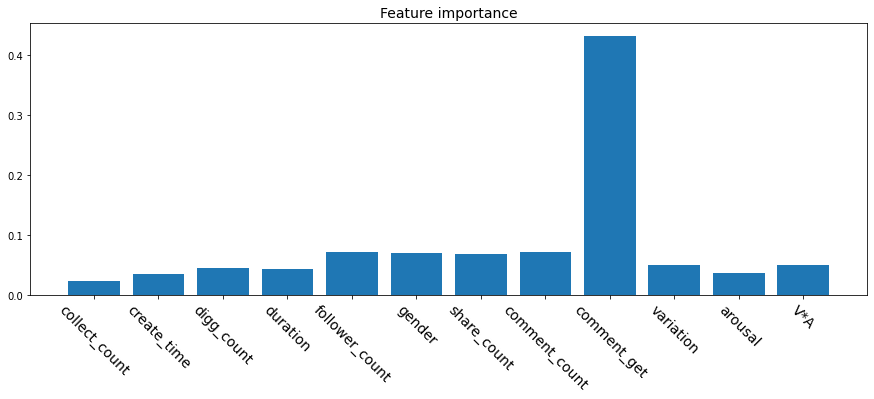

In [5]:
# 获取feature importance
import matplotlib.pyplot as plt
cols=rawdata.iloc[:,:-1].columns
plt.figure(figsize=(15, 5))
plt.bar(range(len(cols)), model.feature_importances_)
pd.DataFrame()
plt.xticks(range(len(cols)), cols, rotation=-45, fontsize=14)
plt.title('Feature importance', fontsize=14)
plt.savefig(save+'feature_importance.png')
plt.show()

In [6]:
imp=pd.DataFrame(model.feature_importances_,index=cols).T
imp

,collect_count,create_time,digg_count,duration,follower_count,gender,share_count,comment_count,comment_get,variation,arousal,V*A
0,0.024065,0.034735,0.044777,0.044105,0.072116,0.070075,0.068382,0.072753,0.432156,0.049601,0.037329,0.049904


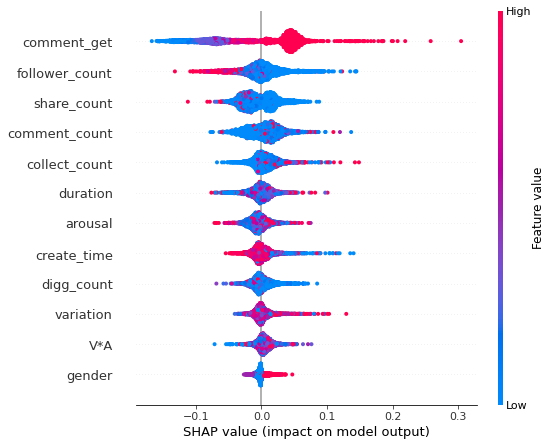

In [7]:
import shap
plt.figure(figsize=(6, 5))
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(rawdata.iloc[:,:-1][cols])
y_base = explainer.expected_value 
shap.summary_plot(shap_values, rawdata.iloc[:,:-1][cols],show=False)
plt.savefig(save+'shap.png')

In [8]:
j = len(imp)
player_explainer = pd.DataFrame()
player_explainer['feature'] = cols
player_explainer['shap_value'] = shap_values[j]
player_explainer


,feature,shap_value
0,collect_count,0.005953
1,create_time,0.078834
2,digg_count,-0.015200
3,duration,-0.011045
4,follower_count,-0.023262
5,gender,0.009492
6,share_count,0.011741
7,comment_count,0.004078
8,comment_get,-0.058948
9,variation,0.014344


In [9]:
player_explainer['XGB_importance']=imp.iloc[0].values
player_explainer.to_csv(save+'import_tabel.csv',index=False,encoding='utf_8_sig')
player_explainer

,feature,shap_value,XGB_importance
0,collect_count,0.005953,0.024065
1,create_time,0.078834,0.034735
2,digg_count,-0.015200,0.044777
3,duration,-0.011045,0.044105
4,follower_count,-0.023262,0.072116
5,gender,0.009492,0.070075
6,share_count,0.011741,0.068382
7,comment_count,0.004078,0.072753
8,comment_get,-0.058948,0.432156
9,variation,0.014344,0.049601


In [10]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score, r2_score

y_true = y_test

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
evs = explained_variance_score(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

metrics = {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'EVS': evs, 'R2': r2}

df = pd.DataFrame(list(metrics.items()), columns=['Metric', 'Value'])
df.to_csv(save+'Metric.csv',index=False,encoding='utf_8_sig')
print(df)

  Metric     Value
0    MAE  0.095159
1    MSE  0.016716
2   RMSE  0.129291
3    EVS  0.198613
4     R2  0.198458
